# SyriaTel Communications Project: Customer Churn (Binary Classification)

### Table of Contents

1. Introduction + Cleaning + EDA: Exploration of the data without intensive technologies. 
2. Modeling the Data
3. Question One
4. Question Two
5. Question Three
6. Conclusion: The findings repeated in a concise summary.

### Strategic Approach

The stakeholder, SyriaTel, is a telecommunications company whose goal is to better understand what factors are causing customer churn. Due to limits on data size, the model will only be robust enough to be used by SyriaTel to analyze their specific data provided.

By exploring typical customer churn and using the CRISP-DM framework, I will seek to answer the following questions: 

1. What features of the dataset are primary determinants of customer churn and to what extent?

2. What are the ways that these findings can be interpreted and how can SyriaTel implement cost-effective solutions?

3. Will these solutions be feasible in reducing the customer churn rate by at least 7%?

### Importing Relevant Packages

In [139]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import itertools
from imblearn.over_sampling import SMOTE, ADASYN
import imblearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, confusion_matrix, classification_report, recall_score
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC
from numpy import loadtxt
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import dtreeviz.trees

### Unpickling the DataFrame

In [2]:
df = pd.read_pickle("data/df.pkl")  

In [3]:
df.head()

,intl_plan,qty_vmails,cust_serv_calls,churn,monthly_charge
0,0,25,1,0.0,75.56
1,0,26,1,0.0,59.24
2,0,0,0,0.0,62.29
3,1,0,2,0.0,66.80
4,1,0,3,0.0,52.09


### Defining X and Y

In [4]:
X = df.drop(columns='churn')
y = df.churn

### Checking the New Class Sizes

In [5]:
y.value_counts()

0.0    2850
1.0     483
Name: churn, dtype: int64

In [6]:
X.shape

(3333, 4)

### Train Test Split

A random state of 42 will be used to stabilize the results. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print('Training Set: ')
print(y_train.value_counts())
print('Normalized:')
print(y_train.value_counts(normalize=True))
print('\n')
# Test set
print('Test Set')
print(y_test.value_counts())
print('Normalized:')
print(y_test.value_counts(normalize=True))

Training Set: 
0.0    2284
1.0     382
Name: churn, dtype: int64
Normalized:
0.0    0.856714
1.0    0.143286
Name: churn, dtype: float64


Test Set
0.0    566
1.0    101
Name: churn, dtype: int64
Normalized:
0.0    0.848576
1.0    0.151424
Name: churn, dtype: float64


### Seeking a Model to Maximize Recall:

Having a false negative (Type II Error), would mean that the model is predicting that the customer is not going to cancel when they actually are. For this reason, priority is given to the metric of recall.

### Logistic Regression Model

Here, a ROC Curve can be used to show the performance of a classification model at all classification thresholds. This curve plots two parameters: true positive rate and false positive rate. 

Area Under the ROC Curve (AUC): An aggregated metric that evaluates how well a logistic regression model classifies positive and negative outcomes at all possible cutoffs. It can range from 0.5 to 1, and the larger it is the better.

The AUC of .79 indicates that this model is sorting the values at an acceptable way, but not an excellent way.

AUC: 0.5392191162579155


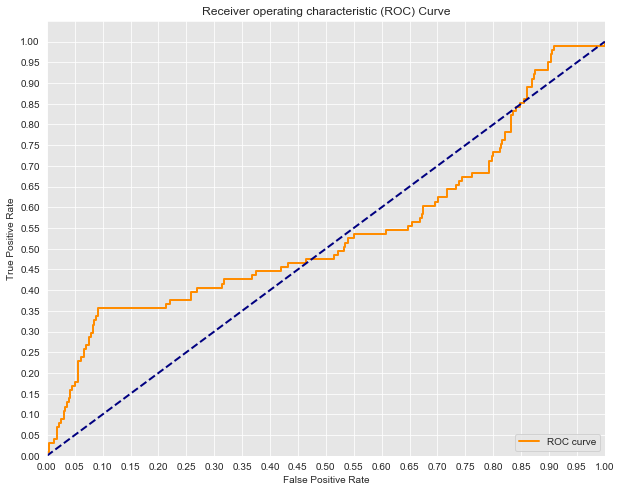

In [9]:
# Initial Model #what does the solver indicate?
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC

print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw=lw, label='ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw=lw, linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
y_pred = logreg.predict(X_test)

### Logistic Regression Evaluation

In [11]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[546,  20],
       [ 88,  13]])

### Confusion Matrix Breakdown:
 - 553 True Negatives: Predicting that they will not cancel and being correct.
 - 13 False Positives: Predicting that they will cancel and being wrong. 
 - 86 False Negatives: Predicting that they're not going to cancel and being wrong.
 - 15 True Positive: Predicting that they will cancel and being correct.

### Recall Calculation: Avoiding the worst scenario.

In the case of this project, a Type II Error would be worse than a Type I Error. A Type II Error would indicate a false negative, meaning that SyriaTel would predict that their customer would not churn, and they would be incorrect. This is much worse than a Type I Error or a false positive where SyriaTel predicts that the customer would churn and they do not. 

Since a Type II Error is a worse scenario when it comes to the business application of the findings, which means recall is the ideal metric to optimize for. Recall here is measuring how good the model is at predictin the cancellations.

.14 for recall is low so other models should be utilized.

In [12]:
recall_score(y_test, y_pred)

0.12871287128712872

# K-Nearest Neighbors Model

In [13]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)

In [14]:
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.9253731343283582
Recall Score: 0.6138613861386139
Accuracy Score: 0.9340329835082459
F1 Score: 0.738095238095238


Optimizing the model for the best value of K.

In [15]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
    
    print("Best Value for k: {}".format(best_k))
    print("Recall: {}".format(best_score))

# K-Nearest Neighbors Evaluation

In [16]:
find_best_k(X_train, y_train, X_test, y_test)

Best Value for k: 1
Recall: 0.6831683168316832


# Decision Tree Model

In [17]:
SEED = 1

In [18]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

Here we have a fairly high AUC. 

In [19]:
# Make predictions using test set 
y_pred = dt.predict(X_test)

# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8433684357835076

Here we have a fairly high AUC and recall.

In [20]:
recall_score(y_test, y_pred)

0.7326732673267327

# Descision Tree Experimentation with Default Settings

The Decision Tree Model did not perform well with the Default Settings. 

In [21]:
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=4,
                           max_depth=3,
                           min_samples_split=0.7,
                           min_samples_leaf=0.25, 
                           random_state= SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

In [22]:
print('Recall: ', recall_score(y_test, y_pred))

Recall:  0.0


# Tuning the Decision Tree Model

Train AUC, and Test AUC will be indicative of training and test error for learning.

### Identifying Ideal Maximum Tree Depth

5 is the ideal maximum tree depth. Greater tree depth is indicative of overfitting as Train AUC soars above Test AUC. At 6, the Test AUC is above the Train AUC.

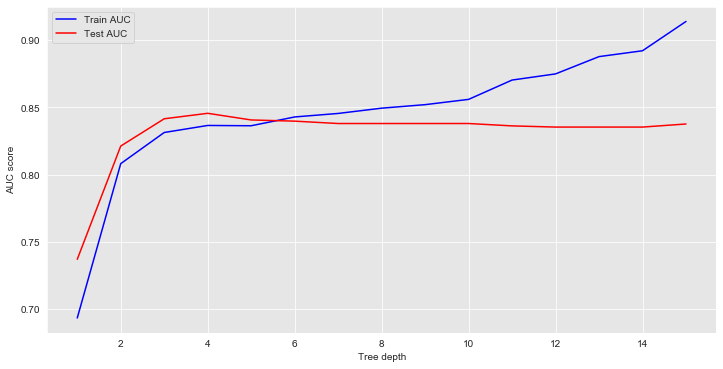

In [23]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()


### Identifying Ideal Minimum Sample Split

.3 would be the ideal number for sample split. Larger split does not improve learning. 

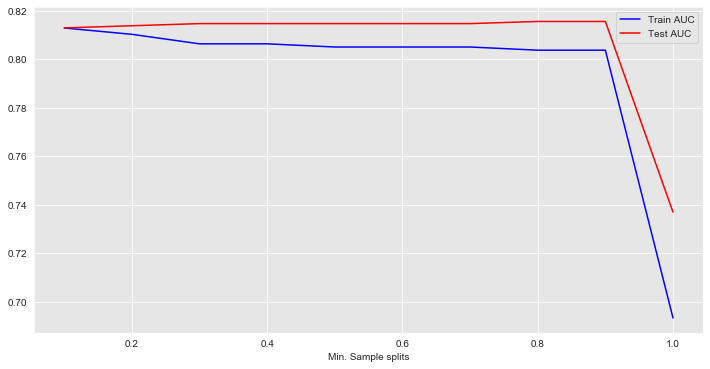

In [24]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

### Identifying Ideal Minimum Sample Leafs

AUC for Training and test are best at .07 as greater values cause them to separate. 

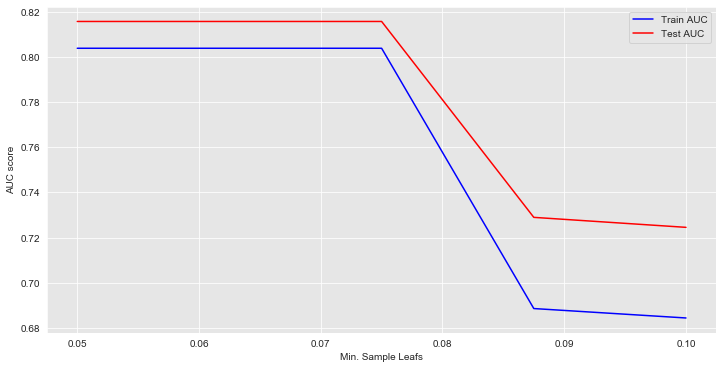

In [25]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.05, .1, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

### Identifying Ideal Maximum Features

Best fit number is 2.

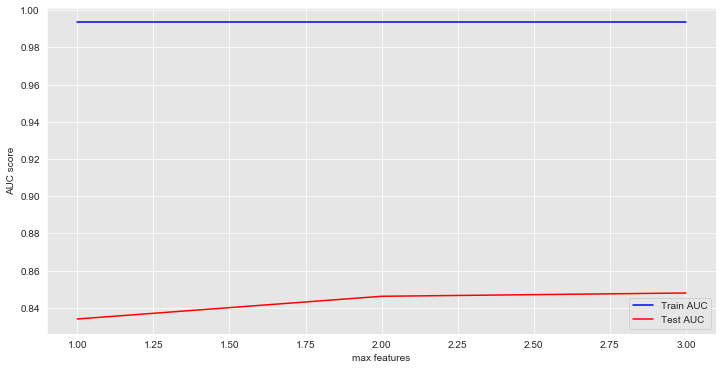

In [26]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

### Retraining the Classifier with Optimal Values

These values will allow the model to incorporate the maximum amount of positive learning possible.

In [100]:
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=2,
                           max_depth=5,
                           min_samples_split=0.3,
                           min_samples_leaf=0.07, 
                           random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8156159255501522

In [101]:
recall_score(y_test, y_pred) 

0.693069306930693

In [102]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[531  35]
 [ 31  70]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       566
         1.0       0.67      0.69      0.68       101

    accuracy                           0.90       667
   macro avg       0.81      0.82      0.81       667
weighted avg       0.90      0.90      0.90       667



In [103]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

Testing Accuracy for Decision Tree Classifier: 90.1%


In [104]:
dt.feature_importances_

array([0.23038837, 0.00220351, 0.28756495, 0.47984317])

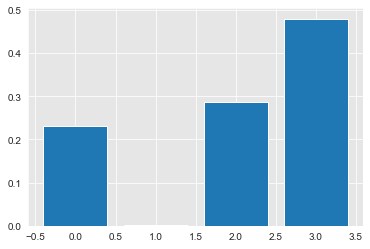

In [105]:
plt.bar(range(len(dt.feature_importances_)), dt.feature_importances_)
plt.show()

# Bagged Trees + Decision Tree Model with Gini Impurity

The bagging classifier is used to reduce variance in the dataset. Decision trees have low bias but high variance which can lead to overfitting and drastic output changes when minute input changes are made.

In [33]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=4), 
                                 n_estimators=20, random_state = SEED)

In [34]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                  n_estimators=20, random_state=1)

In [35]:
# Returns the mean accuracy of training set
bagged_tree.score(X_train, y_train)


0.9516129032258065

In [36]:
# Returns the mean accuracy of testing set
bagged_tree.score(X_test, y_test)

0.952023988005997

In [37]:
y_pred = bagged_tree.predict(X_test)

In [38]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[566   0]
 [ 32  69]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       566
         1.0       1.00      0.68      0.81       101

    accuracy                           0.95       667
   macro avg       0.97      0.84      0.89       667
weighted avg       0.95      0.95      0.95       667



In [39]:
recall_score(y_test, y_pred)

0.6831683168316832

### Optimizing for Entropy

In [40]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=4), 
                                 n_estimators=20, random_state = SEED)

In [41]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=4),
                  n_estimators=20, random_state=1)

In [42]:
bagged_tree.score(X_train, y_train)


0.9512378094523631

In [43]:
bagged_tree.score(X_test, y_test)

0.952023988005997

In [44]:
y_pred = bagged_tree.predict(X_test)

### Optimizing for entropy made no difference.

In [45]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[566   0]
 [ 32  69]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       566
         1.0       1.00      0.68      0.81       101

    accuracy                           0.95       667
   macro avg       0.97      0.84      0.89       667
weighted avg       0.95      0.95      0.95       667



In [46]:
recall_score(y_test, y_pred)

0.6831683168316832

### Optimizing for Max Depth

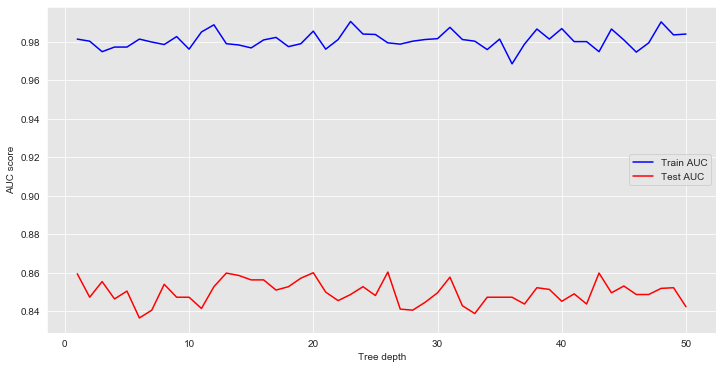

In [47]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state = SEED), n_estimators=20)   
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

### Optimised at 6; Greater max depth would cause overfitting.

In [113]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth= 6), 
                                 n_estimators=20, random_state = SEED)

In [114]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=7),
                  n_estimators=20, random_state=1)

In [115]:
bagged_tree.score(X_train, y_train)


0.9568642160540135

In [116]:
bagged_tree.score(X_test, y_test)

0.9475262368815592

In [117]:
y_pred = bagged_tree.predict(X_test)

### Optimizing for max depth increased recall.

In [118]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[562   4]
 [ 31  70]]
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       566
         1.0       0.95      0.69      0.80       101

    accuracy                           0.95       667
   macro avg       0.95      0.84      0.88       667
weighted avg       0.95      0.95      0.94       667



In [119]:
recall_score(y_test, y_pred)

0.693069306930693

# Gradient Boost Model

Gradient Boost uses the next possible best model combined with previous models to minimize the overall prediction error. The prediction error in this classification model measures how well the model predicts the variable of a customer churning.

In [55]:
gbt_clf = GradientBoostingClassifier(random_state=SEED)

In [56]:
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

In [57]:
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

### Training Scores

In [58]:
print_metrics(y_train, gbt_clf_train_preds)

Precision Score: 1.0
Recall Score: 0.7172774869109948
Accuracy Score: 0.959489872468117
F1 Score: 0.8353658536585367


### Testing Scores

In [59]:
print_metrics(y_test, gbt_clf_test_preds)

Precision Score: 0.971830985915493
Recall Score: 0.6831683168316832
Accuracy Score: 0.9490254872563718
F1 Score: 0.8023255813953488


In [60]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       566
         1.0       0.97      0.68      0.80       101

    accuracy                           0.95       667
   macro avg       0.96      0.84      0.89       667
weighted avg       0.95      0.95      0.95       667



In [61]:
recall_score(y_test, y_pred)

0.6831683168316832

# Adaboost Model

In [62]:
adaboost_clf = AdaBoostClassifier(random_state= SEED)

In [63]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

In [64]:
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

### Training Scores

In [65]:
print_metrics(y_train, adaboost_train_preds)

Precision Score: 0.8346456692913385
Recall Score: 0.5549738219895288
Accuracy Score: 0.9204801200300075
F1 Score: 0.6666666666666667


### Testing Scores

In [66]:
print_metrics(y_test, adaboost_test_preds)

Precision Score: 0.8333333333333334
Recall Score: 0.594059405940594
Accuracy Score: 0.9205397301349325
F1 Score: 0.6936416184971098


In [67]:
recall_score(y_test, y_pred)

0.6831683168316832

# Random Forest Model

In [68]:
forest = RandomForestClassifier(n_estimators=20, max_depth= 11, random_state = SEED)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=20, random_state=1)

In [69]:
y_pred = forest.predict(X_test)

In [70]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[558   8]
 [ 27  74]]
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       566
         1.0       0.90      0.73      0.81       101

    accuracy                           0.95       667
   macro avg       0.93      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



In [71]:
forest.score(X_train, y_train)

0.9726181545386346

In [72]:
forest.score(X_test, y_test)

0.9475262368815592

In [73]:
recall_score(y_test, y_pred)

0.7326732673267327

# XGBoost Model

In [74]:
xg = XGBClassifier(random_state = SEED)

xg.fit(X_train, y_train)

training_preds = xg.predict(X_train)
test_preds = xg.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Training Accuracy: 95.65%
Validation accuracy: 95.35%
Training Recall: 70.68%
Test Recall: 70.3%


# Tuning XGBoost Model with GridSearchCV

In [75]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [76]:
grid_xg = GridSearchCV(xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xg.fit(X_train, y_train)

best_parameters = grid_xg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xg.predict(X_train)
test_preds = grid_xg.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 97.67%
Validation accuracy: 94.6%
Training Recall: 84.55%
Test Recall: 70.3%


# XGBoost with Optimal Parameters

### The Optimal Parameters Increased

In [77]:
xg = XGBClassifier(max_depth = 6, learning_rate = .1, n_estimators = 100, min_child_weight = 1, subsample = .7, random_state = SEED)

xg.fit(X_train, y_train)

training_preds = xg.predict(X_train)
test_preds = xg.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Training Accuracy: 97.04%
Validation accuracy: 94.45%
Training Recall: 79.84%
Test Recall: 70.3%


In [78]:
xg.feature_importances_

array([0.3660278 , 0.19751514, 0.22469237, 0.21176471], dtype=float32)

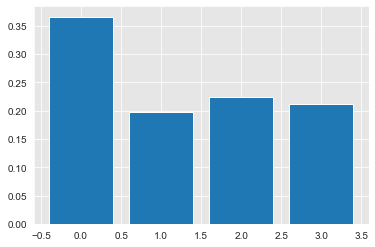

In [79]:
plt.bar(range(len(xg.feature_importances_)), xg.feature_importances_)
plt.show()

# Best Performing Models

The Decision Tree Model with Entropy selected, and the Random Forest Model both had a recal of .7326. This amount of recall is considered acceptable. I am deciding to continue with the Decision Tree model for further analysis as decision trees can be easier to interpret. 

In [121]:
SEED = 1

In [122]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [123]:
# Make predictions using test set 
y_pred = dt.predict(X_test)

# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8433684357835076

In [124]:
recall_score(y_test, y_pred)

0.7326732673267327

### Importance of Features From the Decision Tree Model

ValueError: tree must be Booster, XGBModel or dict instance

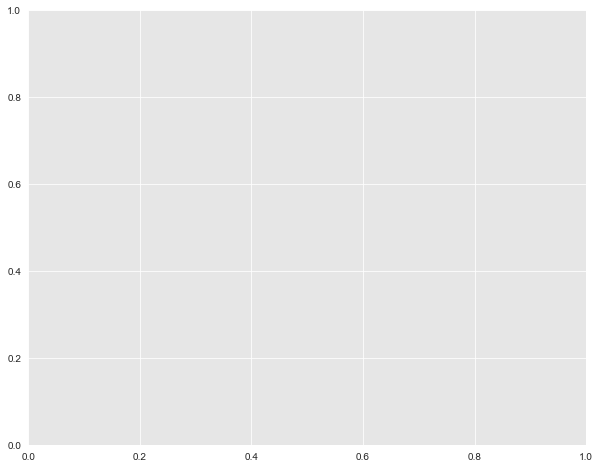

In [125]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(dt, ax=ax)

### Top Features to Include in Tuning

- Monthly Charge
- Qty of Voicemails
- Customer Service Calls
- International Plan

# XGBoost with Top Feature Selection

In [81]:
xg = XGBClassifier(random_state = SEED)

xg.fit(X_train, y_train)

training_preds = xg.predict(X_train)
test_preds = xg.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Training Accuracy: 95.65%
Validation accuracy: 95.35%
Training Recall: 70.68%
Test Recall: 70.3%


# XGBoost with Top Feature Selection and GridSearchCV

In [82]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [83]:
grid_xg = GridSearchCV(xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xg.fit(X_train, y_train)

best_parameters = grid_xg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xg.predict(X_train)
test_preds = grid_xg.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 97.67%
Validation accuracy: 94.6%
Training Recall: 84.55%
Test Recall: 70.3%


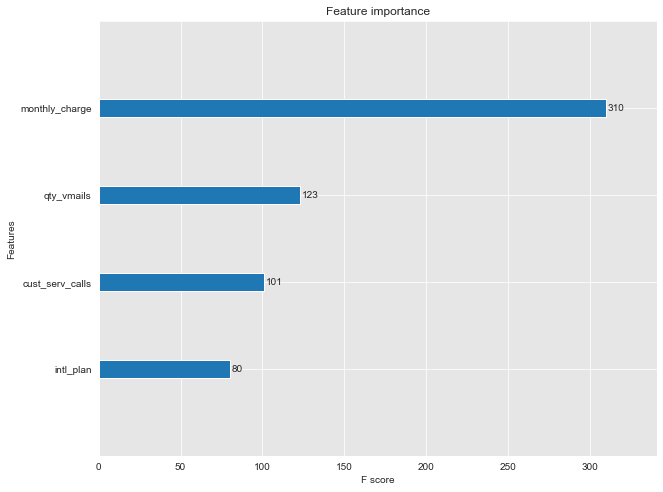

In [84]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xg, ax=ax)

# Computing Importance with SHAP (SHapley Additive exPlanations) Values

In [86]:
X_display,y_display = shap.datasets.nhanesi(display=True)

In [87]:
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X_test)

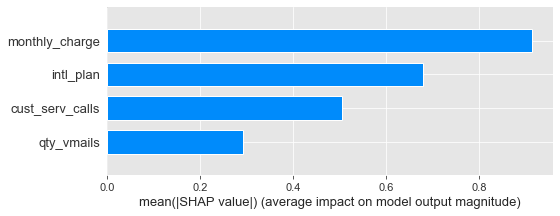

In [88]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Initiating Javascript

In [89]:
shap.initjs()

### Features Contributing to Pushing Model Output

The graph below shows features each contributing to push the model output from the base value to the model output. Features pushing the prediction higher are shown in red. Those pushing the prediction lower are in blue. The number associated with the feature shows the balue that is impacting churn.

In [90]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [91]:
X.shape

(3333, 4)

### Reading the SHAP Value Summary Plot

On the right hand side of the graph, the legend for feature value indicates that red is high feature value and blue is low feature value. On the y axis, the features are divided individually. The x axis at the bottom ranks how significant the impact is. Summarizing, blue on the far right of a feature would indicate that low feature value has a high impact of churn, while red would indicate that high feature value has a high impact of churn. 

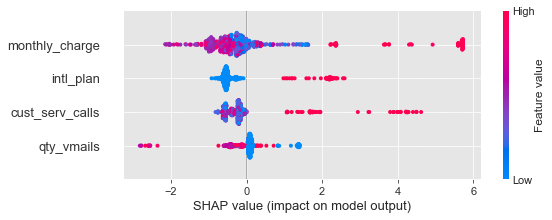

In [92]:
shap.summary_plot(shap_values, X_test, title = 'SHAP Values by Feature')

### Observing Features by SHAP Values

### Contributors of High Customer Churn

- High Monthly Charge
- High Number of Customer Service Calls
- Having an International Plan (Binary Variable)

